# Statevector simulator

Quick solution to the exercise of Lecture 2.

In [96]:
import numpy as np
import matplotlib.pyplot as plt

gate_dic = {
    "H": np.array([[1, 1], [1, -1]])/np.sqrt(2),
    "CNOT": np.array([[1, 0, 0, 0],
                      [0, 1, 0, 0],
                      [0, 0, 0, 1],
                      [0, 0, 1, 0]
                     ]),
    "RX": lambda theta : np.cos(theta/2) * np.identity(2) - 1j * np.sin(theta/2)*np.array([[0, 1], [1, 0]], np.complex128),
    "RY": lambda theta : np.cos(theta/2) * np.identity(2) - 1j * np.sin(theta/2)*np.array([[0, -1j], [1j, 0]], np.complex128),
    "RZ": lambda theta : np.cos(theta/2) * np.identity(2) - 1j * np.sin(theta/2)*np.array([[1, 0], [0, -1]], np.complex128)

}

class Circuit:
    def __init__(self, nqbits, gates):
        self.nqbits = nqbits
        self.gates = gates
        
    def add(self, gate_tuple):
        self.gates.append(gate_tuple)
        
    def __str__(self):
        string = ""
        for gt in self.gates:
            string += str(gt) + "\n"
        return string


class State:
    def __init__(self, nqbits):
        self.nqbits = nqbits
        self.shape = (2,)*nqbits
        self.state = np.zeros(self.shape, np.complex128)
        self.state[(0,)*nqbits] = 1
        
    def apply(self, gate, qbits, param=None):
        self.state = np.moveaxis(self.state, qbits, np.arange(len(qbits)))
        self.state = np.reshape(self.state, (2**len(qbits), 2**(self.nqbits - len(qbits))))
        matrix = gate_dic[gate] if param is None else gate_dic[gate](param)
        self.state = matrix.dot(self.state)
        self.state = np.reshape(self.state, self.shape)
        self.state = np.moveaxis(self.state, np.arange(len(qbits)), qbits)
        
    def __str__(self):
        state = self.to_vec()
        
        string = ""
        for ind in range(2**self.nqbits):
            string += "|"+format(ind, '0'+str(self.nqbits)+'b')+">" +" : "+str(state[ind])+" \n"
        return string
        
    def to_vec(self):
        return np.reshape(self.state, 2**self.nqbits)
    
class StateVectorQPU:
    def __init__(self, nqbits):
        self.state = State(nqbits)
        
    def submit(self, circuit):
        assert(circuit.nqbits == self.state.nqbits)
        for gate_tuple in circuit.gates:
            self.state.apply(*gate_tuple)
            
        return self.state

# a couple of tests
psi = State(2)
print(psi)
psi.apply("H", [0])
print(psi)
psi.apply("CNOT", [0, 1])
print(psi)
psi.apply("CNOT", [0, 1])
print(psi)
psi.apply("CNOT", [1, 0])
print(psi)
psi.apply("RY", [1], np.pi/2)
print(psi)

# test with a circuit
circ = Circuit(2, [("H", [0]), ("CNOT", [0, 1])])

qpu = StateVectorQPU(2)
res = qpu.submit(circ)

print(res)



|00> : (1+0j) 
|01> : 0j 
|10> : 0j 
|11> : 0j 

|00> : (0.7071067811865475+0j) 
|01> : 0j 
|10> : (0.7071067811865475+0j) 
|11> : (-0+0j) 

|00> : (0.7071067811865475+0j) 
|01> : 0j 
|10> : 0j 
|11> : (0.7071067811865475+0j) 

|00> : (0.7071067811865475+0j) 
|01> : 0j 
|10> : (0.7071067811865475+0j) 
|11> : 0j 

|00> : (0.7071067811865475+0j) 
|01> : 0j 
|10> : (0.7071067811865475+0j) 
|11> : 0j 

|00> : (0.5000000000000001+0j) 
|01> : (0.5+0j) 
|10> : (0.5000000000000001+0j) 
|11> : (0.5+0j) 

|00> : (0.7071067811865475+0j) 
|01> : 0j 
|10> : 0j 
|11> : (0.7071067811865475+0j) 



## Playing with random circuits

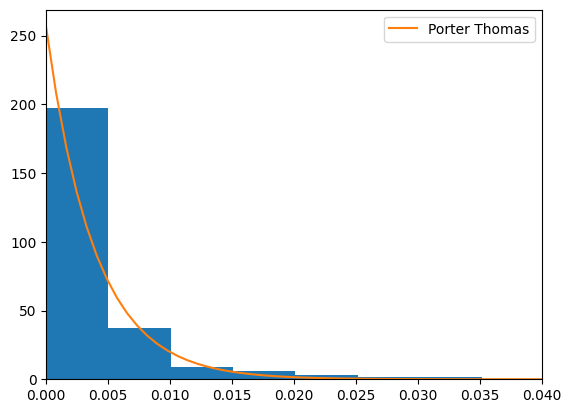

In [109]:
def random_circuit(nqbits, nlayers):
    circ = Circuit(nqbits, [])
    for indl in range(nlayers):
        for qb in range(nqbits):
            rot = "R" + np.random.choice(["X", "Y", "Z"])
            angle = np.random.random()*2*np.pi
            circ.add((rot, [qb], angle))
        for qb in range(nqbits-1 - indl%2):
            circ.add(("CNOT", [qb+indl%2, qb+1+indl%2]))
    return circ

nqbits = 8
circ = random_circuit(nqbits, 6)
qpu = StateVectorQPU(nqbits)
res2 = qpu.submit(circ)

data = abs(res2.to_vec())**2
probs_b = np.linspace(0, 1., 200)
plt.hist(data, bins=probs_b)
probs = np.linspace(0, 0.04, 50)

plt.plot(probs, 2**nqbits * np.exp(- 2**nqbits * probs), label = "Porter Thomas")
plt.legend()
plt.xlim(0,0.04);